In [13]:
using PyCall
println(PyCall.python)

/Users/miyata/spin-system-simulations/.venv/bin/python


In [14]:
include("IsingCore.jl")
using .IsingCore
using StochasticAD
using CairoMakie
using Optimisers
using LinearAlgebra
using Statistics: mean, std

println(names(IsingCore))

# hyper parameters
T0 = [5.0]
N = 6 # size of the lattice, N x N

function optimize(θ0; move=IsingCore.independent_sampler, is_move=false, η=0.01, n=200, n_batch=1)
    optimizer = Adam(η)
    θ = deepcopy(θ0)
    θ_trace = [θ]
    setup = Optimisers.setup(optimizer, θ)
    for i in 1:n
        samples = [derivative_estimate(T -> obj(T; move, is_move), θ[1]) for _ in 1:n_batch]
        g = mean(samples)
        s = std(samples)
        setup, θ = Optimisers.update(setup, θ, g)
        push!(θ_trace, deepcopy(θ))
        if i % 10 == 0
            println("Iteration $i: mean = $g, std = $s, T = $(θ[1])")
        end
    end
    return θ_trace
end

function obj(T; move=IsingCore.independent_sampler, is_move=false)
    config = IsingCore.initial_state(N)
    if is_move
        -IsingCore.ising_model_remc(N, T, config, move)[3]
    else
        -IsingCore.ising_model(N, T, config, move)[3]
    end
end

[:IsingCore, :calc_energy, :calc_mag, :independent_sampler, :initial_state, :ising_model, :ising_model_manyT, :ising_model_remc, :metropolis_sampler]


obj (generic function with 2 methods)

In [15]:
θ_trace_re = optimize(T0; move=IsingCore.metropolis_sampler, is_move=true, η=0.01, n=300, n_batch=50)
obj_trace_re = [-obj(θ[1]; move=IsingCore.metropolis_sampler, is_move=true) for θ in θ_trace_re]
println("finish to optimize replica exchange.")

Iteration 10: mean = -11.40013390203843, std = 195.13133433286205, T = 5.031858055834856
Iteration 20: mean = -6.9880065290167535, std = 190.9998350804486, T = 5.077642016314966
Iteration 30: mean = -6.362296211705637, std = 237.1618021910149, T = 5.12837580641464
Iteration 40: mean = 31.843643598000085, std = 222.507126693559, T = 5.144854803164431
Iteration 50: mean = -8.396531922482325, std = 187.08994569253844, T = 5.148983292605067
Iteration 60: mean = -15.874784417663298, std = 166.20921502826414, T = 5.146604640484514
Iteration 70: mean = -0.5301407763827501, std = 182.911565066529, T = 5.146439096312006
Iteration 80: mean = -48.56111522842852, std = 156.55050910886393, T = 5.156282318454184
Iteration 90: mean = 7.274863458353389, std = 234.31761264826932, T = 5.185246820124922
Iteration 100: mean = -9.529335000945698, std = 216.61595707694514, T = 5.200417519429221
Iteration 110: mean = -10.473463572746793, std = 189.4355178705255, T = 5.230604921347096
Iteration 120: mean = 20

In [16]:
θ_trace = optimize(T0; move=IsingCore.metropolis_sampler, η=0.01, n=300, n_batch=50)
obj_trace = [-obj(θ[1], move=IsingCore.metropolis_sampler) for θ in θ_trace]
println("finish to optimize.")

Iteration 10: mean = -31.287359622607575, std = 144.52162035088244, T = 5.043857268875711
Iteration 20: mean = -15.354137432050642, std = 148.79996777519054, T = 5.094417809244588
Iteration 30: mean = -0.03500985137274256, std = 113.91282842995855, T = 5.139058727619355
Iteration 40: mean = -1.6300567143230666, std = 119.10402776190882, T = 5.139585628475421
Iteration 50: mean = 0.6743922602140628, std = 121.54414591720054, T = 5.138182030505229
Iteration 60: mean = 20.074887820434565, std = 147.9700002302923, T = 5.135221570480437
Iteration 70: mean = -7.9316418077813955, std = 115.74787557560188, T = 5.146488986388578
Iteration 80: mean = 19.74346898819131, std = 133.8168531477502, T = 5.15817673207285
Iteration 90: mean = 12.810408690975901, std = 147.9657277446879, T = 5.165859408972748
Iteration 100: mean = -23.93433503069027, std = 119.71971303910638, T = 5.207965110024528
Iteration 110: mean = -13.136727127584136, std = 118.667080530445, T = 5.235802014853002
Iteration 120: mean

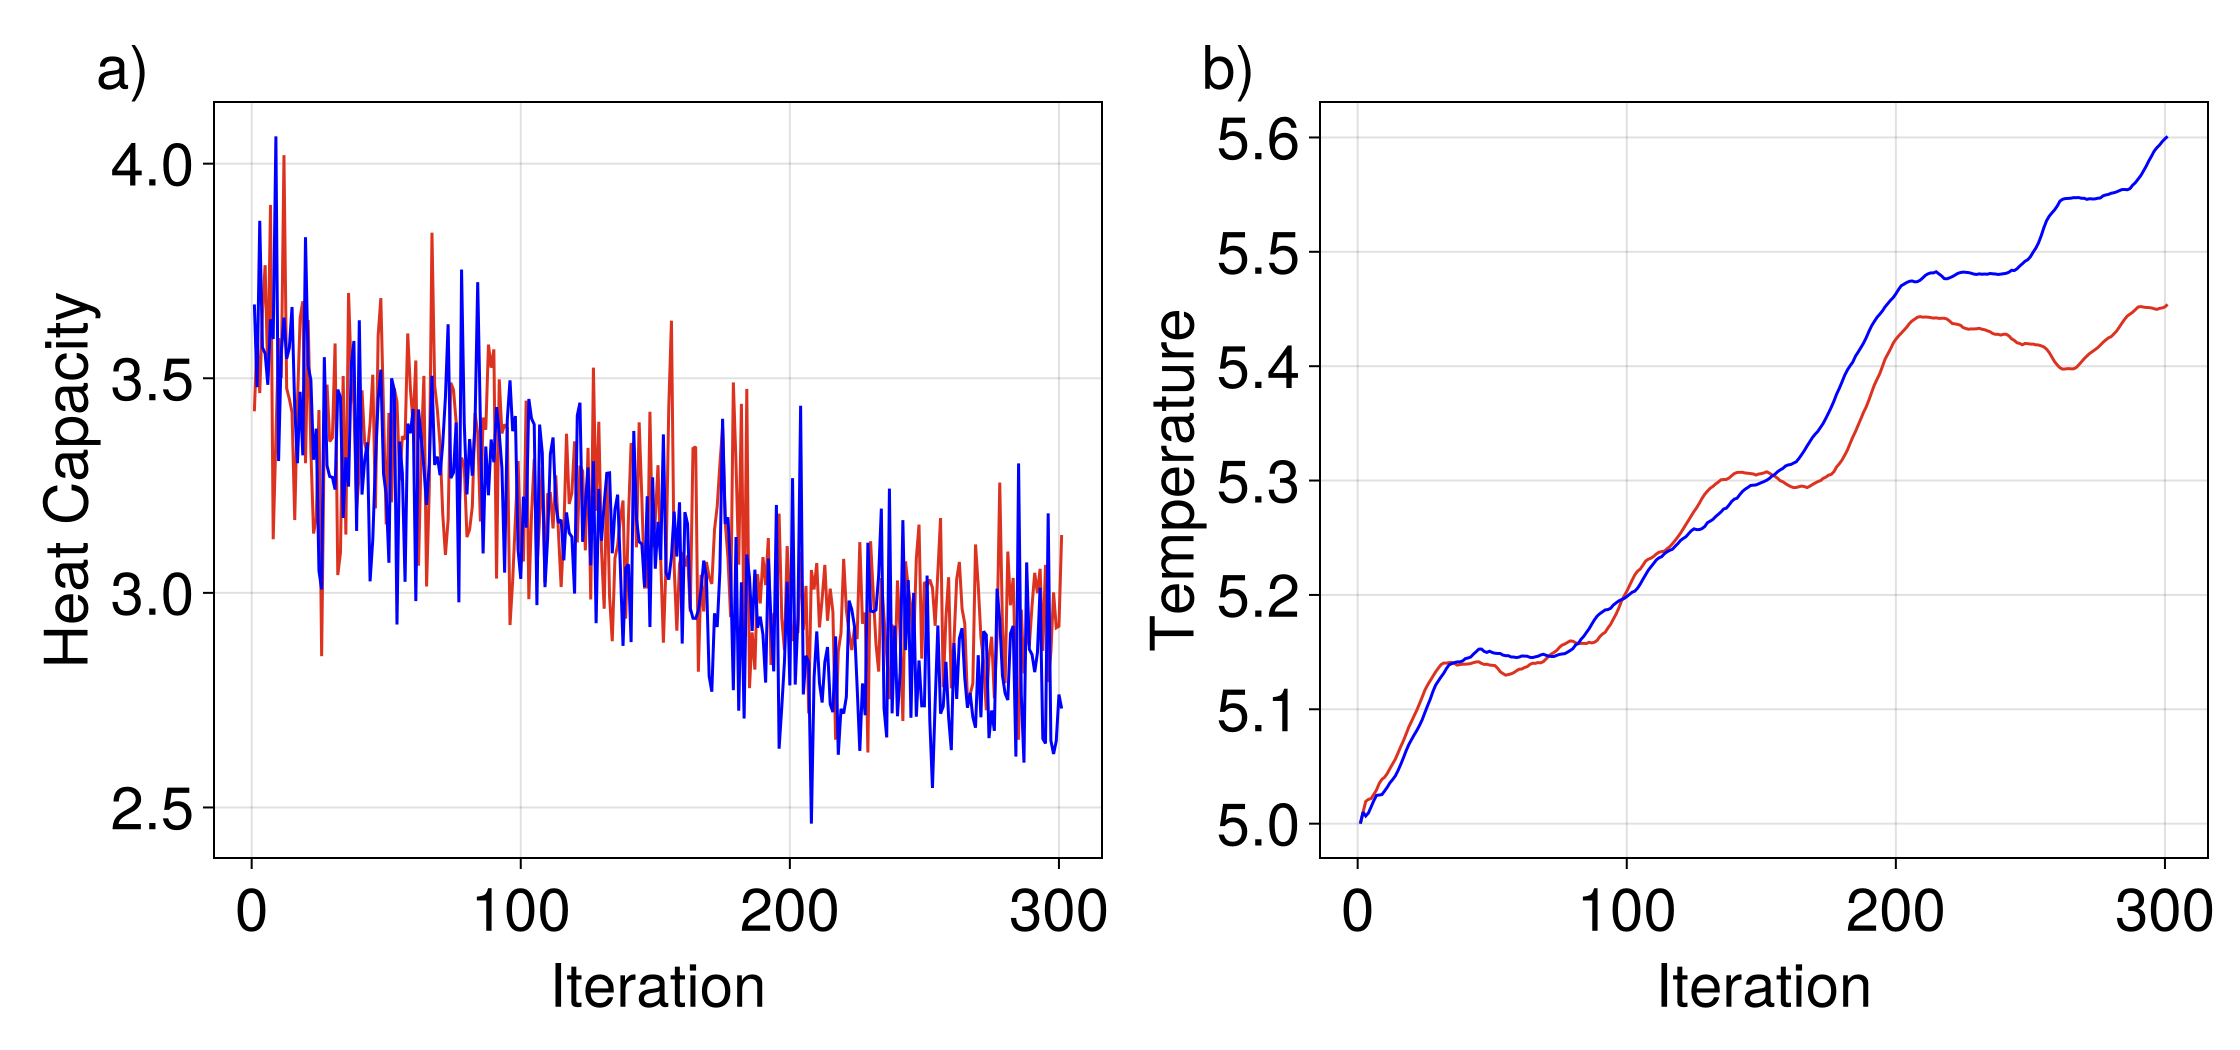

CairoMakie.Screen{IMAGE}


In [17]:
begin
    fig = Figure(size=(1120, 525), fontsize=30)
    ax1 = fig[1, 1] = Axis(fig, ylabel="Heat Capacity", xlabel="Iteration")
    ax2 = fig[1, 2] = Axis(fig, ylabel="Temperature", xlabel="Iteration")
    Label(fig[1, 1, TopLeft()], "a)")
    Label(fig[1, 2, TopLeft()], "b)")

    lines!(ax1, obj_trace, color=Makie.Colors.RGB(220/255,50/255,32/255), label="independent")
    lines!(ax1, obj_trace_re, color=:blue, label="replica exchange")
    lines!(ax2, [θ[1] for θ in θ_trace], color=Makie.Colors.RGB(220/255,50/255,32/255), label="independent")
    lines!(ax2, [θ[1] for θ in θ_trace_re], color=:blue, label="replica exchange")
    display(fig)
end